#1) 논문 전체 구조 요약
##1. Introduction

기존 SOTA는 RNN/LSTM 기반 인코더-디코더 + (부가적으로) attention이 주류.

문제: RNN은 시점(t)마다 순차적으로 계산 → 병렬화가 거의 불가. 길이가 길어질수록 학습/추론이 느리고, 장거리 의존 학습도 불리.

제안: 순환(recurrence)과 합성곱을 모두 제거하고, attention만으로 입력-출력 의존성을 학습하는 Transformer 제시.


##2. Background

CNN 기반(ByteNet/ConvS2S)도 병렬화를 얻지만, 멀리 떨어진 토큰 관계를 연결하려면 여러 층이 필요(경로 길이가 커짐).

Self-attention은 한 층에서도 전 위치를 직접 연결할 수 있음(경로가 짧아짐).


##3. Model Architecture

Encoder-Decoder 스택 + 각 층은 (Self-Attention) + (Position-wise FFN) 구조.

디코더에는 추가로 **Encoder-Decoder Attention(크로스 어텐션)**이 들어감.

각 서브레이어에 Residual + LayerNorm 적용.


##4. Why Self-Attention

“왜 self-attention이 좋은가”를 복잡도/병렬성/장거리 경로 길이로 비교(표 1). 핵심은

RNN: O(n) 순차 연산, 경로 길이 O(n)

Self-attention: 순차 연산 O(1), 경로 길이 O(1) (한 층에서 멀리도 바로 연결)



> 이후 5~7장은 학습 세팅/결과/결론(번역 성능, 파싱 등)입니다.

#2) Self-Attention: 왜 필요한가 + 어떻게 문맥을 계산하는가
##핵심 아이디어

>각 토큰의 표현을 만들 때, “이 토큰이 문장에서 누구를 얼마나 참고해야 하는지”를 학습해서 가중합으로 새 표현을 만든다.


##Q/K/V의 의미(왜 이렇게 나누는가)

Query(Q): “나는 무엇이 필요하다(무엇을 찾겠다)”

Key(K): “나는 이런 특징을 갖고 있다(매칭 신호)”

Value(V): “참조될 때 실제로 전달할 정보(내용 벡터)”

즉, Q·K로 ‘관련도’를 계산하고, 그 관련도로 V를 섞어(가중합) 문맥화된 표현을 만든다.

#3) Scaled Dot-Product Attention: ‘스케일링’이 왜 필요한가?![캡처.PNG]
논문식:

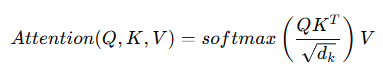

왜 루트dk로 나누나?
- dk가 커지면
QKT값의 분산이 커져서 softmax 입력이 너무 커짐.

- 그러면 softmax가 거의 0/1로 포화되어 그래디언트가 작아지고 학습이 불안정해질 수 있음.

- 그래서
 루트dk로 나눠 스케일을 안정화.

#4) Multi-Head Attention: 왜 head를 여러 개로 쪼개나?
###“한 번의 attention”의 한계(평균의 함정)

attention의 출력은 결국 “V의 가중 평균”이라서, 하나의 관점만으로 섞으면

- 다양한 관계(구문/의미/지시어/장거리 의존 등)를 동시에 잡기 어렵고

- 평균으로 뭉개져 해상도(표현력)가 줄어드는 문제가 생김.

###Multi-Head의 목적

- 서로 다른 투영(Linear projection)으로 다른 표현 부분공간(subspace) 에서 attention을 병렬로 수행

- 어떤 head는 주어-동사, 어떤 head는 지시어(its 등), 어떤 head는 장거리 연결을 담당하는 식으로 역할 분화가 가능

#5) Positional Encoding: 순환이 없는데 ‘순서’는 어떻게 아나?
###문제(순환/합성곱 제거의 부작용)

Self-attention만 있으면 입력은 사실상 집합(set) 처럼 보일 수 있어서,

- “나는 i번째 토큰”이라는 순서 정보가 없다면
문장 구조(어순)가 무너짐.

###해결: Embedding에 위치 정보를 더한다

논문은 (학습형도 가능하지만) sin/cos 기반 고정 positional encoding을 사용:
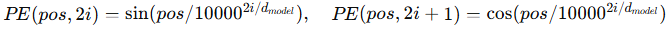
###왜 sin/cos인가(“왜 필요한가” 관점)

- 모델이 “상대적 거리” 패턴을 선형적으로 다루기 쉬울 거라는 가정(특정 offset은 표현 변환으로 잡히기 쉬움)

- 학습에서 보지 못한 더 긴 길이에도 외삽(extrapolation) 가능성을 기대

#6) Position-wise Feed Forward Network(FFN): attention만으로는 부족한 점

FFN은 각 위치에 독립적으로 동일한 MLP(Linear-ReLU-Linear) 를 적용:

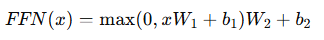
###왜 필요한가?

- Attention은 기본적으로 “토큰들 사이에서 정보를 섞는(mix) 연산”에 강함.

- 하지만 섞인 결과를 비선형적으로 변환하고, 특징을 “재조합/정제”하는 단계가 필요.

- 그래서 한 층은 보통
(관계 결합: attention) → (표현 변환: FFN) 으로 역할이 분리됨.

#7) Residual Connection & Layer Normalization: 깊은 네트워크를 학습시키는 장치

논문은 각 서브레이어에 대해:

image.png

###왜 필요한가?

- Residual(스킵 연결): 깊어져도 정보/그래디언트가 잘 흐르게 해서 학습 안정화(“망가지지 않게”).

- LayerNorm: 배치 크기/길이 변화에도 비교적 안정적인 정규화로 학습을 수렴시키기 쉬움.

- 결과적으로 Transformer는 “attention만 쓰는데도” 6층 이상을 안정적으로 쌓아 성능을 끌어올릴 수 있음.

#8) Encoder / Decoder 전체 흐름(모듈들이 어떻게 합쳐지나)
##Encoder (N=6층)

각 층:

1. Multi-Head Self-Attention (입력 내부 관계)

2. FFN
- 각 서브레이어마다 Residual + LayerNorm

- → 출력: 입력 시퀀스의 문맥화된 표현
𝑧
1
.
.
𝑧
𝑛

##Decoder (N=6층)

각 층:

1. Masked Multi-Head Self-Attention

- “미래 토큰을 보면 안 됨” → causal mask로 i가 i+1..을 못 보게 막음(자기회귀 유지)

2. Encoder-Decoder Attention(크로스 어텐션)

- Q는 디코더(현재 생성 상태), K/V는 인코더 출력(입력 문장 메모리)

3. FFN
- 각 서브레이어마다 Residual + LayerNorm

- → 마지막 Linear + Softmax로 다음 토큰 분포 예측

#9) RNN/LSTM과의 구조적 차이점(본질)
###(1) 계산 흐름: “시간축 순차” vs “한 번에 전 위치”

- RNN/LSTM:
ℎ
𝑡=
𝑓
(
ℎ
𝑡
−
1
,
𝑥
𝑡
)

  - → t가 1부터 n까지 순서대로 처리해야 해서 병렬화가 어렵고, 긴 문장일수록 느림.


- Transformer: 모든 위치의 Q/K/V를 행렬로 만들고 행렬곱으로 한 번에 계산
  - → 한 샘플 내부에서도 병렬화가 크게 가능.

###(2) 장거리 의존성의 “경로 길이”

- RNN: t와 t+k의 정보가 만나려면 hidden state를 k번 “전달”해야 함 → 경로 O(n)

- Self-attention: 한 층에서 모든 위치가 직접 연결 → 경로 O(1)

###(3) “기억”의 방식

- RNN/LSTM: 기억은 압축된 hidden state에 누적(병목이 생기기 쉬움)

- Transformer: 매 층에서 각 토큰이 “전체 토큰”을 가중합으로 직접 참조(필요한 정보에 직접 접근)

#10) 트랜스포머가 순환 없이 문맥을 처리할 수 있는 이유(핵심 논리)

1. Self-Attention이 ‘문맥화’ 자체를 수행

   - 각 토큰 표현이 “다른 모든 토큰의 정보(V)”를 필요에 맞게 섞어 만들어짐

2. Positional Encoding이 ‘순서’를 주입

    - attention이 어떤 토큰이 앞/뒤인지, 얼마나 떨어져 있는지를 학습할 수 있는 기반 제공

3. Multi-Head로 관계를 분해해서 동시에 학습

    - 구문/의미/지시어/장거리 연결 등 서로 다른 의존을 병렬로 포착

4. Stacking(여러 층)으로 고차 구조를 구성

    - 1층은 단순 관계, 위층은 더 추상적/복합적 관계를 만들며 점진적으로 문맥이 정교해짐

5. Decoder는 마스크로 자기회귀 성질 유지 + Cross-Attention으로 입력 조건부 생성

    - “미래를 보지 않으면서도”, 입력 문장의 전체 정보를 언제든 참조 가능